In [1]:
import pandas as pd
from pandas import Series, DataFrame
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss
from scipy.stats import ttest_ind
from scipy.stats import levene

In [2]:
purchase = pd.read_csv('QVI_purchase_behaviour.csv')
transaction = pd.read_excel('QVI_transaction_data.xlsx')

## Overall Inspecting

In [3]:
# First look on dataset
print(purchase.head())
print('\n' + 'Number of rows and columns')
print(purchase.shape)
print('\n' + '------------------------------------------' + '\n')
print(transaction.head())
print('\n' + 'Number of rows and columns')
print(transaction.shape)

   LYLTY_CARD_NBR               LIFESTAGE PREMIUM_CUSTOMER
0            1000   YOUNG SINGLES/COUPLES          Premium
1            1002   YOUNG SINGLES/COUPLES       Mainstream
2            1003          YOUNG FAMILIES           Budget
3            1004   OLDER SINGLES/COUPLES       Mainstream
4            1005  MIDAGE SINGLES/COUPLES       Mainstream

Number of rows and columns
(72637, 3)

------------------------------------------

    DATE  STORE_NBR  LYLTY_CARD_NBR  TXN_ID  PROD_NBR  \
0  43390          1            1000       1         5   
1  43599          1            1307     348        66   
2  43605          1            1343     383        61   
3  43329          2            2373     974        69   
4  43330          2            2426    1038       108   

                                  PROD_NAME  PROD_QTY  TOT_SALES  
0    Natural Chip        Compny SeaSalt175g         2        6.0  
1                  CCs Nacho Cheese    175g         3        6.3  
2    Smiths Crinkl

In [4]:
#Checking the data tpyes
print(purchase.dtypes)
print('\n' + '--------------------------------' + '\n')
print(transaction.dtypes)

LYLTY_CARD_NBR       int64
LIFESTAGE           object
PREMIUM_CUSTOMER    object
dtype: object

--------------------------------

DATE                int64
STORE_NBR           int64
LYLTY_CARD_NBR      int64
TXN_ID              int64
PROD_NBR            int64
PROD_NAME          object
PROD_QTY            int64
TOT_SALES         float64
dtype: object


## Dealing with Date

In [5]:
# Transform date format
def trans_date(date):
    norm_date = pd.to_datetime('1899-12-30') + pd.Timedelta(str(date)+'d')
    return norm_date

transaction['DATE'] = transaction['DATE'].apply(trans_date)

In [6]:
transaction['DATE'].head()

0   2018-10-17
1   2019-05-14
2   2019-05-20
3   2018-08-17
4   2018-08-18
Name: DATE, dtype: datetime64[ns]

In [7]:
#Checking whether there is any missing date
DATE_SORTED = DataFrame(transaction['DATE'].unique()).sort_values(by=0, ascending=True)
DATE_SORTED.reset_index(drop=True,inplace=True) # All date in dataset in correct order
ALL_TIME = DataFrame(pd.date_range('7/1/2018', '6/30/2019')) # All date

#The missing date
ALL_TIME[0].iloc[ALL_TIME[0].isin(DATE_SORTED[0])[ALL_TIME[0].isin(DATE_SORTED[0]) == False].index]

177   2018-12-25
Name: 0, dtype: datetime64[ns]

## Checking Null Values

In [8]:
print(purchase.isnull().sum())
print(transaction.isnull().sum())

LYLTY_CARD_NBR      0
LIFESTAGE           0
PREMIUM_CUSTOMER    0
dtype: int64
DATE              0
STORE_NBR         0
LYLTY_CARD_NBR    0
TXN_ID            0
PROD_NBR          0
PROD_NAME         0
PROD_QTY          0
TOT_SALES         0
dtype: int64


## Checking Duplicated Values

In [9]:
print(purchase[purchase.duplicated()])
print('------------')
print(transaction[transaction.duplicated()])

Empty DataFrame
Columns: [LYLTY_CARD_NBR, LIFESTAGE, PREMIUM_CUSTOMER]
Index: []
------------
             DATE  STORE_NBR  LYLTY_CARD_NBR  TXN_ID  PROD_NBR  \
124845 2018-10-01        107          107024  108462        45   

                                     PROD_NAME  PROD_QTY  TOT_SALES  
124845  Smiths Thinly Cut   Roast Chicken 175g         2        6.0  


In [10]:
#Delete the duplicated values
transaction.drop_duplicates(inplace=True)

#Because we drop some rows, so we need to resetting the index
transaction.reset_index(drop=True,inplace=True)

## Checking Outliers

In [11]:
#Checking whethere there is any unreasonable qty and amount
transaction[(transaction['TOT_SALES'] <= 0) | (transaction['PROD_QTY'] <= 0)].count()

DATE              0
STORE_NBR         0
LYLTY_CARD_NBR    0
TXN_ID            0
PROD_NBR          0
PROD_NAME         0
PROD_QTY          0
TOT_SALES         0
dtype: int64

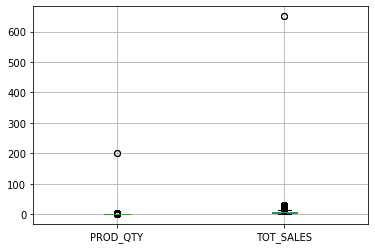

In [12]:
#Checking extreme values by boxplot
boxplot = transaction.boxplot(column=['PROD_QTY','TOT_SALES'])

In [13]:
transaction[transaction['PROD_QTY'] > 100]

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
69762,2018-08-19,226,226000,226201,4,Dorito Corn Chp Supreme 380g,200,650.0
69763,2019-05-20,226,226000,226210,4,Dorito Corn Chp Supreme 380g,200,650.0


In [14]:
# Checking who the buyer and other orders of this buyer
purchase[purchase['LYLTY_CARD_NBR'] == 226000]

,LYLTY_CARD_NBR,LIFESTAGE,PREMIUM_CUSTOMER
59694,226000,OLDER FAMILIES,Premium


In [15]:
# For chips buying activities, normallly people don't buy 200 units, so let's delete the 69762 & 69763
transaction = transaction.drop(index=[69762, 69763])

In [16]:
# Checking whether there are wrong LYLTY_CARD_NBR
transaction[~transaction.LYLTY_CARD_NBR.isin(purchase['LYLTY_CARD_NBR'])]

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES


In [17]:
#Because we drop some rows, so we need to resetting the index
transaction.reset_index(drop=True,inplace=True)

## Dealing with Product Name & other Product features

In [18]:
transaction['PROD_NAME']

0           Natural Chip        Compny SeaSalt175g
1                         CCs Nacho Cheese    175g
2           Smiths Crinkle Cut  Chips Chicken 170g
3           Smiths Chip Thinly  S/Cream&Onion 175g
4         Kettle Tortilla ChpsHny&Jlpno Chili 150g
                            ...                   
264828     Kettle Sweet Chilli And Sour Cream 175g
264829               Tostitos Splash Of  Lime 175g
264830                    Doritos Mexicana    170g
264831     Doritos Corn Chip Mexican Jalapeno 150g
264832               Tostitos Splash Of  Lime 175g
Name: PROD_NAME, Length: 264833, dtype: object

In [19]:
#Splitting the product name and weight
# Removing duplicated spaces and special characters
#Assume the frist words of product name are all brand name, and the last ones are weight

transaction['PROD_NAME'].replace(r'(\d+)', r' \1', inplace=True, regex=True) # space before weight
transaction['PROD_NAME'].replace(r'\s+' , ' ', inplace=True, regex=True) # remove extra space
transaction['PROD_NAME'].replace(r'\&', ' ', inplace=True, regex=True) # remove &

TEMP_PROD_SPLIT = transaction['PROD_NAME'].str.split() # split PROD_NAME
transaction['BRAND_NAME'] = TEMP_PROD_SPLIT.str[0]
transaction['WEIGHT_g'] = TEMP_PROD_SPLIT.str[-1]
transaction['CHIP_NAME'] = TEMP_PROD_SPLIT.str[1:-1]

#For Weight, Kettle 135g Swt Pot Sea Salt is a outlier, we need to fix this
transaction['WEIGHT_g'].replace('Salt', '135g', inplace=True)
#Delete g in WEIGHT and Change it to int
transaction['WEIGHT_g'].replace(r'[a-zA-Z]', '', inplace=True, regex=True)
transaction['WEIGHT_g'] = transaction['WEIGHT_g'].astype('int64')

In [20]:
#Add unit price of product
transaction['UNIT_PRICE'] = transaction['TOT_SALES']/transaction['PROD_QTY']

In [21]:
#Checking the words in chip name
MOST_COMM = transaction['CHIP_NAME'].apply(lambda x: Series(x))

In [22]:
MOST_COMM.melt()['value'].value_counts().head(20)

Chips       49770
Cheese      27890
Salt        24719
Crinkle     23960
Corn        22061
Original    21560
Cut         20753
Chip        18645
Chicken     18576
Salsa       18094
Chilli      15390
Sea         14145
Sour        13882
Crisps      12607
Vinegar     12402
Sweet       11060
Supreme     10961
Chives      10951
Cream       10723
Popd         9693
Name: value, dtype: int64

In [23]:
# The client is not interested in Salsa, so delete salas items
transaction.drop(MOST_COMM[MOST_COMM.isin(['Salsa']).any(axis=1) == True].index, inplace=True) # Check the rows contain Salsa and drop

In [24]:
#Because we drop some rows, so we need to resetting the index
transaction.reset_index(drop=True,inplace=True)

In [25]:
# Checking the brands
print(transaction['BRAND_NAME'].value_counts())

#Red & RRD are the same brand, so convert all RRD to Red
transaction['BRAND_NAME'].replace('RRD', 'Red', inplace=True)

#Natural & NCC are the same brand, so convert all NCC to Natural
transaction['BRAND_NAME'].replace('NCC', 'Natural', inplace=True)

Kettle        41288
Smiths        27389
Pringles      25102
Doritos       22041
Thins         14075
RRD           11894
Infuzions     11057
WW            10320
Cobs           9693
Tostitos       9471
Twisties       9454
Tyrrells       6442
Grain          6272
Natural        6050
Cheezels       4603
CCs            4551
Red            4427
Dorito         3183
Infzns         3144
Smith          2963
Cheetos        2927
Snbts          1576
Burger         1564
Woolworths     1516
GrnWves        1468
Sunbites       1432
NCC            1419
French         1418
Name: BRAND_NAME, dtype: int64


## Combine two tables

In [26]:
comb_table = transaction.merge(purchase, on='LYLTY_CARD_NBR', how='left')

In [27]:
comb_table.columns.values

array(['DATE', 'STORE_NBR', 'LYLTY_CARD_NBR', 'TXN_ID', 'PROD_NBR',
       'PROD_NAME', 'PROD_QTY', 'TOT_SALES', 'BRAND_NAME', 'WEIGHT_g',
       'CHIP_NAME', 'UNIT_PRICE', 'LIFESTAGE', 'PREMIUM_CUSTOMER'],
      dtype=object)

In [28]:
comb_table.to_csv('comb_dataset.csv')

### Basic info of data

In [29]:
purchase[['LIFESTAGE', 'PREMIUM_CUSTOMER']].apply(lambda x: x.value_counts()).T.stack()

LIFESTAGE         MIDAGE SINGLES/COUPLES     7275.0
                  NEW FAMILIES               2549.0
                  OLDER FAMILIES             9780.0
                  OLDER SINGLES/COUPLES     14609.0
                  RETIREES                  14805.0
                  YOUNG FAMILIES             9178.0
                  YOUNG SINGLES/COUPLES     14441.0
PREMIUM_CUSTOMER  Budget                    24470.0
                  Mainstream                29245.0
                  Premium                   18922.0
dtype: float64

In [30]:
transaction[['BRAND_NAME', 'WEIGHT_g']].apply(lambda x: x.value_counts()).T.stack()

BRAND_NAME  Burger         1564.0
            CCs            4551.0
            Cheetos        2927.0
            Cheezels       4603.0
            Cobs           9693.0
            Dorito         3183.0
            Doritos       22041.0
            French         1418.0
            Grain          6272.0
            GrnWves        1468.0
            Infuzions     11057.0
            Infzns         3144.0
            Kettle        41288.0
            Natural        7469.0
            Pringles      25102.0
            Red           16321.0
            Smith          2963.0
            Smiths        27389.0
            Snbts          1576.0
            Sunbites       1432.0
            Thins         14075.0
            Tostitos       9471.0
            Twisties       9454.0
            Tyrrells       6442.0
            WW            10320.0
            Woolworths     1516.0
WEIGHT_g    70             1507.0
            90             3008.0
            110           22387.0
            12

In [31]:
transaction[['STORE_NBR']].apply(lambda x: x.value_counts()).T.stack()

STORE_NBR  226    1916
           88     1786
           165    1741
           237    1714
           93     1699
                  ... 
           252       2
           206       2
           85        2
           76        1
           92        1
Length: 271, dtype: int64

In [32]:
transaction[['PROD_QTY', 'WEIGHT_g', 'TOT_SALES', 'UNIT_PRICE']].describe()

,PROD_QTY,WEIGHT_g,TOT_SALES,UNIT_PRICE
count,246739.000000,246739.000000,246739.000000,246739.000000
mean,1.906456,175.583523,7.316118,3.832419
std,0.342500,59.432239,2.474901,1.077802
min,1.000000,70.000000,1.700000,1.320000
25%,2.000000,150.000000,5.800000,3.000000
50%,2.000000,170.000000,7.400000,3.800000
75%,2.000000,175.000000,8.800000,4.600000
max,5.000000,380.000000,29.500000,6.500000


## First Stage Data Analysis

In [33]:
#For the convince, adding the missing date in to dataset

transaction_group = transaction.append(Series(), ignore_index=True)
transaction_group.iloc[-1,0] = pd.to_datetime('2018-12-25 00:00:00')

C:\Users\Steven\anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  This is separate from the ipykernel package so we can avoid doing imports until


In [34]:
transaction_group["DATE"]

0        2018-10-17
1        2019-05-14
2        2019-05-20
3        2018-08-17
4        2018-08-18
            ...    
246735   2018-08-13
246736   2018-11-06
246737   2018-12-27
246738   2018-09-22
246739   2018-12-25
Name: DATE, Length: 246740, dtype: datetime64[ns]

### Transactions numbers during the year

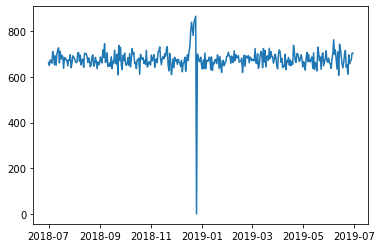

In [35]:
#Transactions numbers during the year
plt.plot(ALL_TIME[0],transaction_group.groupby('DATE')['DATE'].count())

### Total sales in $ during the year

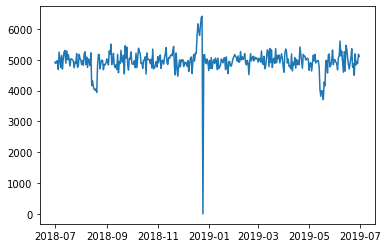

In [36]:
#Total sales in $ during the year
plt.plot(ALL_TIME[0],transaction_group.groupby('DATE')['TOT_SALES'].sum())

In [37]:
#The 10 most $ sales days
transaction_group.groupby('DATE')['TOT_SALES'].sum().sort_values(ascending=False).head(10)

DATE
2018-12-24    6410.9
2018-12-23    6372.1
2018-12-19    6164.7
2018-12-22    6079.8
2018-12-20    5942.8
2018-12-21    5788.3
2018-12-18    5762.2
2019-06-07    5604.9
2018-09-06    5508.6
2019-06-14    5466.4
Name: TOT_SALES, dtype: float64

In [38]:
#The 10 least $ sales days
transaction_group.groupby('DATE')['TOT_SALES'].sum().sort_values().head(10)

DATE
2018-12-25       0.00
2019-05-18    3705.70
2019-05-15    3815.80
2018-08-20    3941.00
2019-05-17    3973.25
2019-05-16    4001.05
2018-08-18    4016.70
2019-05-14    4023.55
2018-08-17    4036.55
2018-08-19    4058.15
Name: TOT_SALES, dtype: float64

### Transaction numbers by size

<BarContainer object of 20 artists>

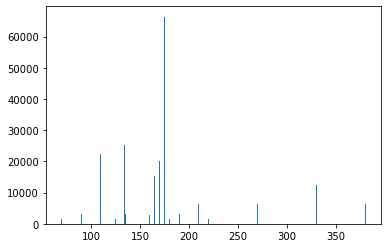

In [39]:
plt.bar(transaction.groupby('WEIGHT_g').count().index, transaction.groupby('WEIGHT_g')['WEIGHT_g'].count())

In [40]:
transaction.groupby('WEIGHT_g')['WEIGHT_g'].count()

WEIGHT_g
70      1507
90      3008
110    22387
125     1454
134    25102
135     3257
150    40203
160     2970
165    15297
170    19983
175    66389
180     1468
190     2995
200     4473
210     6272
220     1564
250     3169
270     6285
330    12540
380     6416
Name: WEIGHT_g, dtype: int64

### The most popular brand

Kettle        41288
Smiths        27389
Pringles      25102
Doritos       22041
Red           16321
Thins         14075
Infuzions     11057
WW            10320
Cobs           9693
Tostitos       9471
Twisties       9454
Natural        7469
Tyrrells       6442
Grain          6272
Cheezels       4603
CCs            4551
Dorito         3183
Infzns         3144
Smith          2963
Cheetos        2927
Snbts          1576
Burger         1564
Woolworths     1516
GrnWves        1468
Sunbites       1432
French         1418
Name: BRAND_NAME, dtype: int64


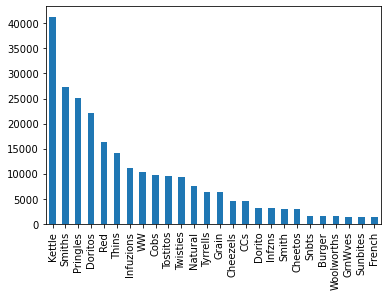

In [41]:
print(transaction['BRAND_NAME'].value_counts())
#Bar chart of the transaction numbers of each brand
transaction['BRAND_NAME'].value_counts().plot.bar()
plt.show()

### Total sales by different group of people

In [42]:
# Total for all
AVE_NUM = comb_table.groupby(['LYLTY_CARD_NBR']).sum()['TOT_SALES'].sum()
print(f'Total number for all is ${AVE_NUM:,.2f}')

Total number for all is $1,805,171.70


In [43]:
pd.pivot_table(comb_table, index=['LIFESTAGE'], values=['TOT_SALES'], aggfunc=[np.sum])\
    .sort_values(('sum', 'TOT_SALES'), ascending=False)

,sum
,TOT_SALES
LIFESTAGE,
OLDER SINGLES/COUPLES,376013.65
RETIREES,342381.90
OLDER FAMILIES,328519.90
YOUNG FAMILIES,294627.90
YOUNG SINGLES/COUPLES,243756.60
MIDAGE SINGLES/COUPLES,172523.80
NEW FAMILIES,47347.95


In [44]:
pd.pivot_table(comb_table, index=['PREMIUM_CUSTOMER'], values=['TOT_SALES'], aggfunc=[np.sum])\
    .sort_values(('sum', 'TOT_SALES'), ascending=False)

,sum
,TOT_SALES
PREMIUM_CUSTOMER,
Mainstream,700865.40
Budget,631406.85
Premium,472899.45


In [45]:
pd.pivot_table(comb_table, index=['LIFESTAGE','PREMIUM_CUSTOMER'], values=['TOT_SALES'], aggfunc=[np.sum])

sum
                                         TOT_SALES
LIFESTAGE              PREMIUM_CUSTOMER           
MIDAGE SINGLES/COUPLES Budget             33345.70
                       Mainstream         84734.25
                       Premium            54443.85
NEW FAMILIES           Budget             20607.45
                       Mainstream         15979.70
                       Premium            10760.80
OLDER FAMILIES         Budget            156863.75
                       Mainstream         96413.55
                       Premium            75242.60
OLDER SINGLES/COUPLES  Budget            127833.60
                       Mainstream        124648.50
                       Premium           123531.55
RETIREES               Budget            105916.30
                       Mainstream        145168.95
                       Premium            91296.65
YOUNG FAMILIES         Budget            129717.95
                       Mainstream         86338.25
                       Premium            78571.70
YOUNG SINGLES/COUPLES  Budget             57122.10
                       Mainstream        147582.20
                       Premium            39052.30

### Sales per family per year by different group of people

In [46]:
# Average for all
AVE_NUM = comb_table.groupby(['LYLTY_CARD_NBR']).sum()['TOT_SALES'].mean()
print(f'Average number for all is ${AVE_NUM:.2f}')

Average number for all is $25.32


In [47]:
pd.pivot_table(comb_table.groupby(['LYLTY_CARD_NBR', 'LIFESTAGE']).sum(), index=['LIFESTAGE'], values=['TOT_SALES'], aggfunc=[np.mean])\
    .sort_values(('mean', 'TOT_SALES'), ascending=False)

,mean
,TOT_SALES
LIFESTAGE,
OLDER FAMILIES,34.114216
YOUNG FAMILIES,32.606009
OLDER SINGLES/COUPLES,26.132021
MIDAGE SINGLES/COUPLES,24.159613
RETIREES,23.523318
NEW FAMILIES,18.999980
YOUNG SINGLES/COUPLES,17.356636


In [48]:
pd.pivot_table(comb_table.groupby(['LYLTY_CARD_NBR', 'PREMIUM_CUSTOMER']).sum(), index=['PREMIUM_CUSTOMER'], values=['TOT_SALES'], aggfunc=[np.mean])\
    .sort_values(('mean', 'TOT_SALES'), ascending=False)

,mean
,TOT_SALES
PREMIUM_CUSTOMER,
Budget,26.302043
Premium,25.497355
Mainstream,24.391501


In [49]:
pd.pivot_table(comb_table.groupby(['LYLTY_CARD_NBR', 'LIFESTAGE', 'PREMIUM_CUSTOMER']).sum(), index=['LIFESTAGE', 'PREMIUM_CUSTOMER'], values=['TOT_SALES'], aggfunc=[np.mean])\
    .sort_values(('mean', 'TOT_SALES'), ascending=False)

mean
                                         TOT_SALES
LIFESTAGE              PREMIUM_CUSTOMER           
OLDER FAMILIES         Mainstream        34.581618
                       Budget            34.019464
                       Premium           33.725952
YOUNG FAMILIES         Budget            32.815065
                       Premium           32.765513
                       Mainstream        32.155773
OLDER SINGLES/COUPLES  Premium           26.384355
                       Budget            26.362879
MIDAGE SINGLES/COUPLES Mainstream        25.692617
OLDER SINGLES/COUPLES  Mainstream        25.658399
RETIREES               Budget            24.154230
                       Premium           23.949803
MIDAGE SINGLES/COUPLES Premium           22.981786
RETIREES               Mainstream        22.832487
MIDAGE SINGLES/COUPLES Budget            22.622592
NEW FAMILIES           Mainstream        19.252651
                       Budget            18.958096
                       Premium           18.714435
YOUNG SINGLES/COUPLES  Mainstream        18.641177
                       Premium           15.746895
                       Budget            15.662764

### Package size chosen by different family

In [50]:
pd.pivot_table(comb_table, index=['LIFESTAGE'], values=['PROD_QTY'], aggfunc=[np.mean])\
    .sort_values(('mean', 'PROD_QTY'), ascending=False)

,mean
,PROD_QTY
LIFESTAGE,
OLDER FAMILIES,1.946410
YOUNG FAMILIES,1.940460
OLDER SINGLES/COUPLES,1.913352
MIDAGE SINGLES/COUPLES,1.901701
RETIREES,1.892593
NEW FAMILIES,1.857781
YOUNG SINGLES/COUPLES,1.834025


In [51]:
pd.pivot_table(comb_table, index=['PREMIUM_CUSTOMER'], values=['WEIGHT_g'], aggfunc=[np.mean])\
    .sort_values(('mean', 'WEIGHT_g'), ascending=False)

,mean
,WEIGHT_g
PREMIUM_CUSTOMER,
Mainstream,175.975895
Premium,175.371084
Budget,175.312694


In [52]:
pd.pivot_table(comb_table, index=['LIFESTAGE', 'PREMIUM_CUSTOMER'], values=['WEIGHT_g'], aggfunc=[np.mean])\
    .sort_values(('mean', 'WEIGHT_g'), ascending=False)

mean
                                           WEIGHT_g
LIFESTAGE              PREMIUM_CUSTOMER            
YOUNG SINGLES/COUPLES  Mainstream        178.344249
MIDAGE SINGLES/COUPLES Mainstream        177.898693
OLDER SINGLES/COUPLES  Premium           176.485657
RETIREES               Budget            176.395641
                       Premium           176.368421
NEW FAMILIES           Mainstream        175.629748
OLDER FAMILIES         Budget            175.546342
YOUNG FAMILIES         Budget            175.459720
OLDER SINGLES/COUPLES  Budget            175.334673
NEW FAMILIES           Premium           175.245296
RETIREES               Mainstream        175.213671
OLDER FAMILIES         Mainstream        175.175666
OLDER SINGLES/COUPLES  Mainstream        174.812145
NEW FAMILIES           Budget            174.766643
YOUNG FAMILIES         Premium           174.659032
MIDAGE SINGLES/COUPLES Premium           174.585391
OLDER FAMILIES         Premium           174.524752
YOUNG FAMILIES         Mainstream        174.202059
MIDAGE SINGLES/COUPLES Budget            174.182690
YOUNG SINGLES/COUPLES  Premium           174.002563
                       Budget            173.378981

In [53]:
# T-test for YOUNG SINGLES/COUPLES BUDGET and YOUNG SINGLES/COUPLES MAINSTREAM

sample_A = comb_table[(comb_table['LIFESTAGE'] == 'YOUNG SINGLES/COUPLES') &\
           (comb_table['PREMIUM_CUSTOMER'] == 'Mainstream')]['WEIGHT_g']
sample_B = comb_table[(comb_table['LIFESTAGE'] == 'YOUNG SINGLES/COUPLES') &\
           (comb_table['PREMIUM_CUSTOMER'] == 'Budget')]['WEIGHT_g']

print(levene(sample_A, sample_B)) # small p-value suggests they do not have equal variances
print(ttest_ind(sample_A, sample_B, equal_var=False)) # small p-value suggests they have significant difference

LeveneResult(statistic=102.0638386928582, pvalue=5.907202592788736e-24)
Ttest_indResult(statistic=6.578124637024347, pvalue=4.8907709584654706e-11)


### Unit per family

In [54]:
pd.pivot_table(comb_table.groupby(['LYLTY_CARD_NBR', 'LIFESTAGE', 'PREMIUM_CUSTOMER']).sum(), index=['LIFESTAGE'], values=['PROD_QTY'], aggfunc=[np.mean])\
    .sort_values(('mean', 'PROD_QTY'), ascending=False)

,mean
,PROD_QTY
LIFESTAGE,
OLDER FAMILIES,9.127310
YOUNG FAMILIES,8.695994
OLDER SINGLES/COUPLES,6.753979
MIDAGE SINGLES/COUPLES,6.231060
RETIREES,6.037444
NEW FAMILIES,4.843499
YOUNG SINGLES/COUPLES,4.436058


In [55]:
pd.pivot_table(comb_table.groupby(['LYLTY_CARD_NBR', 'LIFESTAGE', 'PREMIUM_CUSTOMER']).sum(), index=['PREMIUM_CUSTOMER'], values=['PROD_QTY'], aggfunc=[np.mean])\
    .sort_values(('mean', 'PROD_QTY'), ascending=False)

,mean
,PROD_QTY
PREMIUM_CUSTOMER,
Budget,6.905524
Premium,6.677252
Mainstream,6.291501


In [56]:
pd.pivot_table(comb_table.groupby(['LYLTY_CARD_NBR', 'LIFESTAGE', 'PREMIUM_CUSTOMER']).sum(), index=['LIFESTAGE', 'PREMIUM_CUSTOMER'], values=['PROD_QTY'], aggfunc=[np.mean])\
    .sort_values(('mean', 'PROD_QTY'), ascending=False)

mean
                                         PROD_QTY
LIFESTAGE              PREMIUM_CUSTOMER          
OLDER FAMILIES         Mainstream        9.255380
                       Budget            9.076773
                       Premium           9.071717
YOUNG FAMILIES         Budget            8.722995
                       Premium           8.716013
                       Mainstream        8.638361
OLDER SINGLES/COUPLES  Budget            6.781398
                       Premium           6.769116
                       Mainstream        6.712021
MIDAGE SINGLES/COUPLES Mainstream        6.432080
RETIREES               Budget            6.141847
                       Premium           6.103358
MIDAGE SINGLES/COUPLES Premium           6.078514
                       Budget            6.026459
RETIREES               Mainstream        5.925920
NEW FAMILIES           Mainstream        4.891566
                       Budget            4.821527
                       Premium           4.815652
YOUNG SINGLES/COUPLES  Mainstream        4.575597
                       Premium           4.264113
                       Budget            4.250069

### Unit price per family

In [57]:
pd.pivot_table(comb_table, index=['LIFESTAGE'], values=['UNIT_PRICE'], aggfunc=[np.mean])\
    .sort_values(('mean', 'UNIT_PRICE'), ascending=False)

,mean
,UNIT_PRICE
LIFESTAGE,
NEW FAMILIES,3.906726
YOUNG SINGLES/COUPLES,3.893653
RETIREES,3.889036
MIDAGE SINGLES/COUPLES,3.871211
OLDER SINGLES/COUPLES,3.863078
YOUNG FAMILIES,3.750432
OLDER FAMILIES,3.736389


In [58]:
pd.pivot_table(comb_table, index=['PREMIUM_CUSTOMER'], values=['UNIT_PRICE'], aggfunc=[np.mean])\
    .sort_values(('mean', 'UNIT_PRICE'), ascending=False)

,mean
,UNIT_PRICE
PREMIUM_CUSTOMER,
Mainstream,3.873657
Premium,3.813071
Budget,3.801726


In [59]:
pd.pivot_table(comb_table, index=['LIFESTAGE', 'PREMIUM_CUSTOMER'], values=['UNIT_PRICE'], aggfunc=[np.mean])\
    .sort_values(('mean', 'UNIT_PRICE'), ascending=False)

mean
                                        UNIT_PRICE
LIFESTAGE              PREMIUM_CUSTOMER           
YOUNG SINGLES/COUPLES  Mainstream         4.065642
MIDAGE SINGLES/COUPLES Mainstream         3.994241
RETIREES               Budget             3.924404
                       Premium            3.920942
NEW FAMILIES           Budget             3.917688
                       Mainstream         3.916133
OLDER SINGLES/COUPLES  Premium            3.893236
                       Budget             3.882096
NEW FAMILIES           Premium            3.872110
RETIREES               Mainstream         3.844294
OLDER SINGLES/COUPLES  Mainstream         3.814665
MIDAGE SINGLES/COUPLES Premium            3.770698
YOUNG FAMILIES         Premium            3.762150
                       Budget             3.760737
OLDER FAMILIES         Budget             3.745340
MIDAGE SINGLES/COUPLES Budget             3.743328
OLDER FAMILIES         Mainstream         3.737077
YOUNG FAMILIES         Mainstream         3.724533
OLDER FAMILIES         Premium            3.717000
YOUNG SINGLES/COUPLES  Premium            3.665414
                       Budget             3.657366

In [60]:
# T-test for YOUNG SINGLES/COUPLES BUDGET and YOUNG SINGLES/COUPLES MAINSTREAM

sample_A = comb_table[(comb_table['LIFESTAGE'] == 'YOUNG SINGLES/COUPLES') &\
           (comb_table['PREMIUM_CUSTOMER'] == 'Mainstream')]['UNIT_PRICE']
sample_B = comb_table[(comb_table['LIFESTAGE'] == 'YOUNG SINGLES/COUPLES') &\
           (comb_table['PREMIUM_CUSTOMER'] == 'Budget')]['UNIT_PRICE']

print(levene(sample_A, sample_B)) # small p-value suggests they do not have equal variances
print(ttest_ind(sample_A, sample_B, equal_var=False)) # small p-value suggests they have significant difference

LeveneResult(statistic=106.48919288872399, pvalue=6.382127412511276e-25)
Ttest_indResult(statistic=29.522268430576997, pvalue=2.795698078070072e-186)


### Favourite brand by groups

In [61]:
comb_table[['LIFESTAGE', 'PREMIUM_CUSTOMER', 'BRAND_NAME']].groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER']).agg(lambda x: ss.mode(x)[0][0])

BRAND_NAME
LIFESTAGE              PREMIUM_CUSTOMER           
MIDAGE SINGLES/COUPLES Budget               Kettle
                       Mainstream           Kettle
                       Premium              Kettle
NEW FAMILIES           Budget               Kettle
                       Mainstream           Kettle
                       Premium              Kettle
OLDER FAMILIES         Budget               Kettle
                       Mainstream           Kettle
                       Premium              Kettle
OLDER SINGLES/COUPLES  Budget               Kettle
                       Mainstream           Kettle
                       Premium              Kettle
RETIREES               Budget               Kettle
                       Mainstream           Kettle
                       Premium              Kettle
YOUNG FAMILIES         Budget               Kettle
                       Mainstream           Kettle
                       Premium              Kettle
YOUNG SINGLES/COUPLES  Budget               Kettle
                       Mainstream           Kettle
                       Premium              Kettle